<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#DecisionTreeClassifier" data-toc-modified-id="DecisionTreeClassifier-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>DecisionTreeClassifier</a></span></li><li><span><a href="#RandomForestClassifier" data-toc-modified-id="RandomForestClassifier-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestClassifier</a></span></li><li><span><a href="#LGBMClassifier" data-toc-modified-id="LGBMClassifier-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>LGBMClassifier</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [71]:
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import catboost as cb
import nltk 
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import re 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score

from nltk.corpus import wordnet
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
data = pd.read_csv('/datasets/toxic_comments.csv')

In [5]:
data.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


In [6]:
data = data.drop(columns = 'Unnamed: 0', axis = 1)

In [7]:
data.head(10)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


In [8]:
data.shape

(159292, 2)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [10]:
data.isnull().sum()

text     0
toxic    0
dtype: int64

In [11]:
data.duplicated().sum()

0

In [12]:
data.describe()

,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [13]:
data['text'] = data['text'].str.lower()

In [14]:
data_corpus = data.copy()

In [15]:
corpus = data_corpus['text'].values

In [16]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
def clear_text(text):
    pattern = re.sub(r'[^a-zA-Z]', ' ', text)
    clear = pattern.split()
    lemm = []
    for i in range(len(clear)):
        lemm.append(clear[i])
    return " ".join(lemm)

In [18]:
wnl = WordNetLemmatizer()

def lemma(text):
    return ' '.join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])

In [19]:
for i in tqdm(range(len(corpus))):
    corpus[i] = clear_text(corpus[i])

100%|██████████| 159292/159292 [00:05<00:00, 31018.40it/s]


In [20]:
for i in tqdm(range(len(data_corpus))):
    corpus[i] = lemma(corpus[i])

100%|██████████| 159292/159292 [21:08<00:00, 125.56it/s]


In [21]:
data_corpus = pd.DataFrame(corpus)

In [22]:
data['lemm_text'] = data_corpus[0]

In [23]:
data.head(10)

,text,toxic,lemm_text
0,explanation\nwhy the edits made under my usern...,0,explanation why the edits make under my userna...
1,d'aww! he matches this background colour i'm s...,0,d aww he match this background colour i m seem...
2,"hey man, i'm really not trying to edit war. it...",0,hey man i m really not try to edit war it s ju...
3,"""\nmore\ni can't make any real suggestions on ...",0,more i can t make any real suggestion on impro...
4,"you, sir, are my hero. any chance you remember...",0,you sir be my hero any chance you remember wha...
5,"""\n\ncongratulations from me as well, use the ...",0,congratulation from me a well use the tool wel...
6,cocksucker before you piss around on my work,1,cocksucker before you piss around on my work
7,your vandalism to the matt shirvington article...,0,your vandalism to the matt shirvington article...
8,sorry if the word 'nonsense' was offensive to ...,0,sorry if the word nonsense be offensive to you...
9,alignment on this subject and which are contra...,0,alignment on this subject and which be contrar...


Text(0.5, 1.0, 'Распределение комментариев')

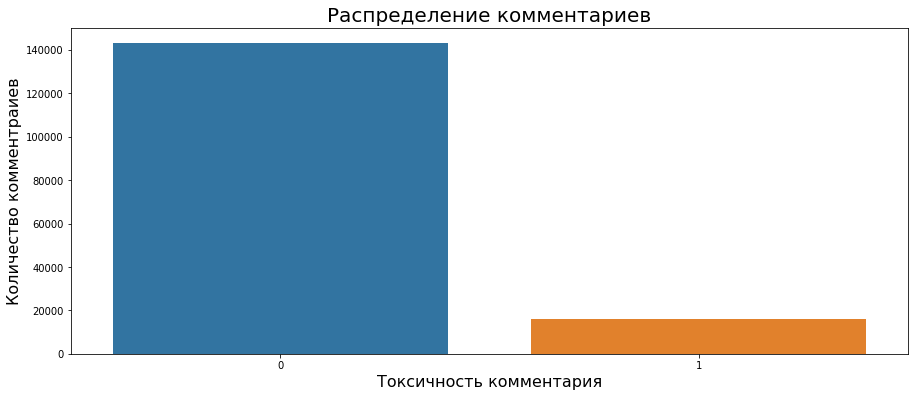

In [24]:
plt.figure(figsize=(15, 6))
sns.countplot(x='toxic', data=data)
plt.xlabel('Токсичность комментария', fontsize = 16)
plt.ylabel('Количество комментраиев', fontsize = 16)
plt.title('Распределение комментариев', fontsize = 20)

Разделим на выборки

In [25]:
feature = data['lemm_text']
target = data['toxic']

In [26]:
feature_train, feature_test, target_train, target_test = train_test_split(feature, target, test_size=0.25)

In [27]:
print(feature_train.shape, feature_test.shape, target_train.shape, target_test.shape)

(119469,) (39823,) (119469,) (39823,)


In [28]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [29]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords) 

feature_train = count_tf_idf.fit_transform(feature_train) 
feature_test = count_tf_idf.transform(feature_test) 

In [30]:
print(feature_train.shape, feature_test.shape)

(119469, 127745) (39823, 127745)


На первом этапе произведена загрузка данных и их подготовка для обучения моделей. Для анализа данных и построения модели предоставлен датасет с размеченными данными.

Дубликатов и пропусков в данных нету. 

Была проведена лемматизация текста и очистка текста. В целевых значениях виден явный дисбаланс. Учтем это при подборе модели обучения. 

## Обучение

In [31]:
metrics_results = pd.DataFrame(columns=['F1'])

In [32]:
def metrics(model_name, F1):
    metrics_results.loc[model_name,'F1'] = F1
    metrics_results['Model'] = metrics_results.index
    return metrics_results

In [35]:
def gridi_train (regressor, parametrs, model_name):
    pipe = Pipeline(
    [
        ('tfidf', TfidfTransformer()),
        ('clf', regressor(random_state=12345))
    ])

    model = GridSearchCV(estimator=pipe,
                         param_grid=parametrs,
                         cv=3,
                         n_jobs=-1,
                         scoring='f1')
    model.fit(feature_train, target_train)
    print('Показатель F1:', model.best_score_, 'при параметрах:', model.best_params_)
    metrics(model_name, model.best_score_)

### LogisticRegression

In [67]:
parametrs_lr = {'clf__solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                'clf__C': [1, 10, 100],
                'clf__max_iter':[10, 25,50],
                'clf__class_weight': ['balanced']}
gridi_train(LogisticRegression, parametrs_lr, 'LogisticRegression')

Показатель F1: 0.7534090486281698 при параметрах: {'clf__C': 10, 'clf__class_weight': 'balanced', 'clf__max_iter': 25, 'clf__solver': 'lbfgs'}


### DecisionTreeClassifier

In [46]:
parametrs_dt = {'clf__class_weight': ['balanced'],
                'clf__max_depth': range(10, 40, 10)
               }
gridi_train(DecisionTreeClassifier, parametrs_dt, 'DecisionTreeClassifier')

Показатель F1: 0.6359991247865195 при параметрах: {'clf__class_weight': 'balanced', 'clf__max_depth': 30}


### RandomForestClassifier

In [47]:
parametrs_rf = {'clf__class_weight': ['balanced'],
                'clf__n_estimators': range(10, 56, 15),
               'clf__max_depth': range(10, 40, 10)
               }
gridi_train(RandomForestClassifier, parametrs_rf, 'RandomForestClassifier')

Показатель F1: 0.4172805040864324 при параметрах: {'clf__class_weight': 'balanced', 'clf__max_depth': 30, 'clf__n_estimators': 55}


### LGBMClassifier

In [60]:
parametrs_lgbm = {'clf__class_weight': ['balanced'],
                  'clf__n_estimators': [10,20],
                  'clf__max_depth': [10,20]
               }
gridi_train(LGBMClassifier, parametrs_lgbm, 'LGBMClassifier')

Показатель F1: 0.6852066647272358 при параметрах: {'clf__class_weight': 'balanced', 'clf__max_depth': 20, 'clf__n_estimators': 20}


In [68]:
metrics_results

,F1,Model
LogisticRegression,0.753409,LogisticRegression
DecisionTreeClassifier,0.635999,DecisionTreeClassifier
RandomForestClassifier,0.417281,RandomForestClassifier
LGBMClassifier,0.685207,LGBMClassifier


Были построенны  моделей машинного обучения. Изучены метрики RMSE и время на предсказание моделей и сведены в общую таблицу

## Тестирование

Посмотрим на все полученные данные

In [69]:
metrics_results

,F1,Model
LogisticRegression,0.753409,LogisticRegression
DecisionTreeClassifier,0.635999,DecisionTreeClassifier
RandomForestClassifier,0.417281,RandomForestClassifier
LGBMClassifier,0.685207,LGBMClassifier


Можем увидеть, что на обучающей выборке лучший результат показал LogisticRegression. Немного уступает LGBMClassifier. Поэтому модель будет тестировать на LogisticRegression

In [70]:
model = LogisticRegression(class_weight = 'balanced', C = 10, solver = 'lbfgs', max_iter = 25)
model.fit(feature_train, target_train)
prediction = model.predict(feature_test)
test_f1 = f1_score(target_test, prediction)
print('Показатель F1:',test_f1)

Показатель F1: 0.751168605283183


## Выводы

В ходе работы было выполнена:
- Предобработка данных;
- Проведена лемматизация текста и очистка текста;
- Построены 5 моделей машинного улучшения для выявления самого подходящего метода;
- С использованием лучшей модели и лучших гиперпараметров, на тренировочной выборке была найдена метрика F1. По итогам построения моделей, была выявлена лучшая для тестовой выборки: LogisticRegression (Показатель метрики F1 на тестовой модели = 0.751)